In [1]:
%run hapclust_utils.ipynb

## Setup data

In [2]:
callset = h5py.File('../ngs.sanger.ac.uk/production/ag1000g/phase1/AR3.1/haplotypes/specific_regions/PARA/2L_2358158_2431617.h5',
                    mode='r')
region_vgsc = SeqFeature('2L', 2358158, 2431617)
genotypes = allel.GenotypeArray(callset['2L/calldata/genotype'])
haplotypes = genotypes.to_haplotypes()
pos = allel.SortedIndex(callset['2L/variants/POS'])
loc = pos.locate_range(region_vgsc.start, region_vgsc.end)
h_vgsc = haplotypes[loc]
pos_995S = 2422651
pos_995F = 2422652
loc_995S = haplotypes[pos.locate_key(pos_995S)] == 1
loc_995F = haplotypes[pos.locate_key(pos_995F)] == 1
h_vgsc_995F = h_vgsc.compress(loc_995F, axis=1)
h_vgsc_995S = h_vgsc.compress(loc_995S, axis=1)

## Plot plot plot...

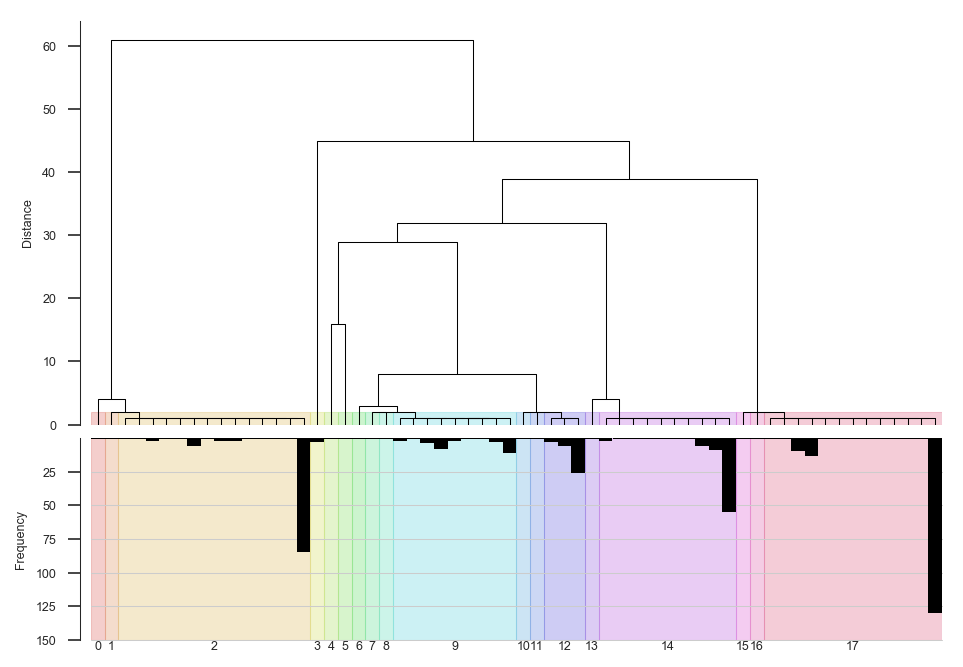

In [4]:
# default plot
fig_haplotypes_clustered(h_vgsc_995S, dpi=150);

In [7]:
# fix h for now
#h = h_vgsc_995S
h = h_vgsc_995F

## Sandbox

In [8]:
distance_metric = 'hamming'

In [9]:
# compute distance matrix
dist = scipy.spatial.distance.pdist(h.T, metric=distance_metric)
if distance_metric in {'hamming', 'jaccard'}:
    # convert distance to number of SNPs, easier to interpret
    dist *= h.n_variants
dist

array([ 3.,  2.,  2., ...,  2.,  2.,  2.])

In [10]:
linkage_method = 'single'

In [11]:
# compute hierarchical clustering
Z = scipy.cluster.hierarchy.linkage(dist, method=linkage_method)
Z

array([[    0.,   774.,     0.,     2.],
       [  491.,   712.,     0.,     2.],
       [  492.,   781.,     0.,     3.],
       ..., 
       [  636.,   655.,    74.,     2.],
       [ 1544.,  1555.,   100.,   778.],
       [ 1556.,  1557.,   125.,   780.]])

> A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

In [12]:
# a value of 0 indicates that each leaf of the dendrogram will represent a unique haplotype
truncate_distance = 0

In [14]:
# find level to truncate dendrogram
lastp = h.n_haplotypes - bisect.bisect_right(Z[:, 2], truncate_distance)
lastp

122

In [144]:
orientation = 'top'

In [145]:
horizontal = orientation in ['left', 'right']
vertical = not horizontal
inverted = orientation in ['bottom', 'right']
horizontal, vertical, inverted

(False, True, False)

In [146]:
figsize = plt.rcParams['figure.figsize']
if horizontal:
    figsize = figsize[::-1]    

<IPython.core.display.Javascript object>


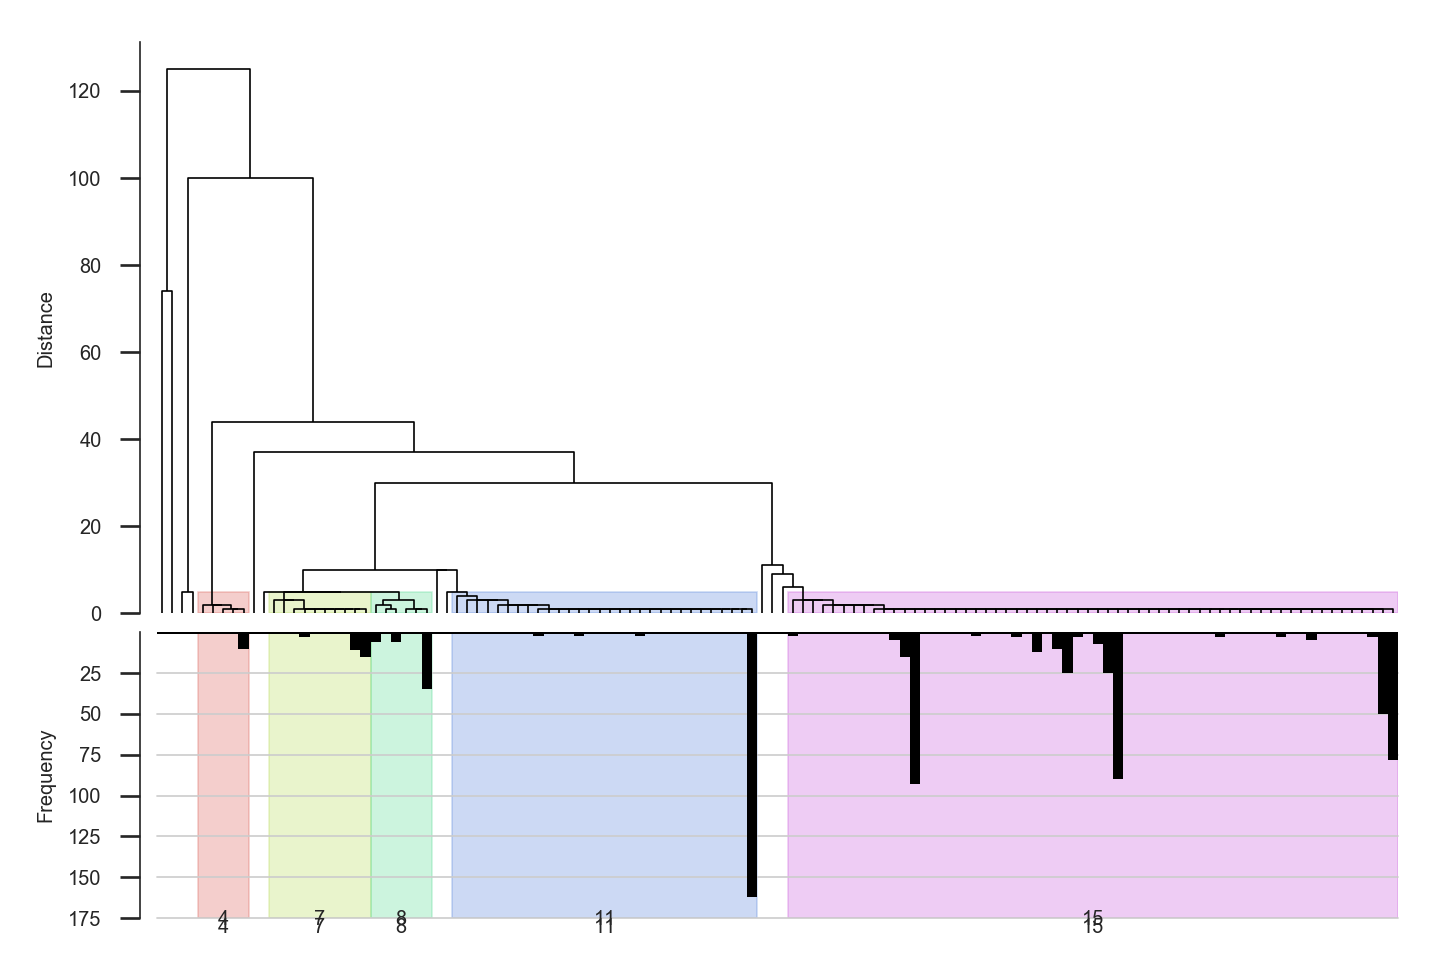

In [147]:
fig = plt.figure(figsize=figsize, dpi=120);

In [148]:
subplot_ratios = [4, 2]
subplot_pad = 0
if inverted:
    subplot_ratios = subplot_ratios[::-1]

if horizontal:
    gs = plt.GridSpec(nrows=1, ncols=2, width_ratios=subplot_ratios)
else:
    gs = plt.GridSpec(nrows=2, ncols=1, height_ratios=subplot_ratios)
    
if inverted:
    ax_dend = fig.add_subplot(gs[1])
    ax_freq = fig.add_subplot(gs[0])
else:
    ax_dend = fig.add_subplot(gs[0])
    ax_freq = fig.add_subplot(gs[1])
    

In [149]:
if horizontal:
    sns.despine(ax=ax_dend, offset=5, left=True, top=True, right=True, bottom=False)
    sns.despine(ax=ax_freq, offset=5, left=True, top=True, right=True, bottom=False)
else:
    sns.despine(ax=ax_dend, offset=5, left=False, top=True, right=True, bottom=True)
    sns.despine(ax=ax_freq, offset=5, left=False, top=True, right=True, bottom=True)
    

In [150]:
# make a dendrogram
kwargs = dict(
    truncate_mode='lastp', 
    p=lastp,
    show_leaf_counts=False, 
    count_sort=True, 
    no_labels=True, 
    color_threshold=0, 
    above_threshold_color='k', 
    orientation=orientation
)    
dend = scipy.cluster.hierarchy.dendrogram(Z, ax=ax_dend, **kwargs)

In [151]:
ax_dend_label = 'Distance'
if horizontal:
    ax_dend.set_xlabel(ax_dend_label)
    ax_dend.set_yticks([])
else:
    ax_dend.set_ylabel(ax_dend_label)
    ax_dend.set_xticks([])


In [152]:
tree = scipy.cluster.hierarchy.to_tree(Z)
tree

In [153]:
leaves = dend['leaves']
s = np.arange(len(leaves))
t = np.array([
    1 if l < h.n_haplotypes
    else tree.get_descendant(l).get_count()
    for l in leaves
])
ax_freq_label = 'Frequency'
if horizontal:
    ax_freq.barh(s, t, height=1, lw=0, color='k', align='edge')
    ax_freq.set_ylim(0, len(leaves))
    ax_freq.set_yticks([])
    ax_freq.set_xlabel(ax_freq_label)
    ax_freq.grid(axis='x', lw=.5)
    if orientation == 'right':
        ax_freq.invert_xaxis()
else:
    ax_freq.bar(s, t, width=1, lw=0, color='k', align='edge')
    ax_freq.set_xlim(0, len(leaves))
    ax_freq.set_xticks([])
    ax_freq.set_ylabel(ax_freq_label)
    ax_freq.grid(axis='y', lw=.5)
    if orientation == 'top':
        ax_freq.invert_yaxis()
    

In [169]:
if horizontal:
    ax_freq.set_xticks(ax_freq.get_xticks()[1:])
else:
    ax_freq.set_yticks(ax_freq.get_yticks()[1:])
    

In [155]:
if horizontal:
    gs.tight_layout(fig, w_pad=subplot_pad)
else:
    gs.tight_layout(fig, h_pad=subplot_pad)
    

In [156]:
cut_height = 5

In [157]:
cut = scipy.cluster.hierarchy.cut_tree(Z, height=cut_height)[:, 0]
cut

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [158]:
cluster_sizes = np.bincount(cut)
cluster_sizes

array([475, 194,  50,  36,  14,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1])

In [159]:
clusters = [np.nonzero(cut == i)[0] for i in range(cut.max() + 1)]
clusters

[array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [160]:
leaf_members = [tree.get_descendant(ix).pre_order() for ix in leaves]
leaf_members

[[636],
 [655],
 [670],
 [671],
 [539],
 [398],
 [503],
 [512],
 [339, 429, 420, 418, 452, 367, 531, 542, 482, 564],
 [557],
 [461],
 [370],
 [377],
 [688],
 [323, 304, 561],
 [709],
 [702],
 [700],
 [699],
 [311, 293, 687, 703, 450, 380, 358, 396, 390, 551, 707],
 [320, 298, 692, 691, 686, 679, 678, 704, 701, 378, 402, 392, 487, 498, 710],
 [343, 333, 331, 301, 361, 385],
 [354],
 [328, 341, 305, 294, 290, 374],
 [463],
 [514],
 [316,
  329,
  340,
  330,
  336,
  334,
  309,
  303,
  300,
  285,
  352,
  427,
  416,
  371,
  364,
  362,
  360,
  386,
  391,
  527,
  536,
  520,
  556,
  555,
  552,
  550,
  549,
  546,
  545,
  483,
  479,
  474,
  506,
  495,
  558],
 [457],
 [469],
 [338],
 [366],
 [346],
 [349],
 [357],
 [455],
 [400],
 [538],
 [460, 488],
 [489],
 [295],
 [296],
 [519, 566],
 [287],
 [408],
 [683],
 [313],
 [563],
 [355, 446],
 [465],
 [382],
 [363],
 [537],
 [513],
 [379],
 [369],
 [322],
 [698],
 [348],
 [308,
  326,
  325,
  324,
  321,
  319,
  318,
  317,
  

In [161]:
leaf_clusters = np.array([cut[m[0]] for m in leaf_members])
leaf_clusters

array([11, 13, 14, 15,  4,  4,  4,  4,  4,  9,  7,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  2,  2,  2,  2,  2,  2,  6,  8,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  5, 10, 12,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [162]:
len(clusters)

16

In [163]:
cluster_spans = list()
c_prv = leaf_clusters[0]
i_start = 0
for i, c in enumerate(leaf_clusters[1:], 1):
    if c != c_prv:
        cluster_spans.append((i_start, i, clusters[c_prv]))
        i_start = i
    c_prv = c
# don't forget the last one
cluster_spans.append((i_start, i+1, clusters[c]))
cluster_spans

[(0, 1, array([636])),
 (1, 2, array([655])),
 (2, 3, array([670])),
 (3, 4, array([671])),
 (4,
  9,
  array([339, 367, 398, 418, 420, 429, 452, 482, 503, 512, 531, 539, 542, 564])),
 (9, 10, array([557])),
 (10, 11, array([461])),
 (11,
  21,
  array([293, 298, 304, 311, 320, 323, 358, 370, 377, 378, 380, 390, 392,
         396, 402, 450, 487, 498, 551, 561, 678, 679, 686, 687, 688, 691,
         692, 699, 700, 701, 702, 703, 704, 707, 709, 710])),
 (21,
  27,
  array([285, 290, 294, 300, 301, 303, 305, 309, 316, 328, 329, 330, 331,
         333, 334, 336, 340, 341, 343, 352, 354, 360, 361, 362, 364, 371,
         374, 385, 386, 391, 416, 427, 463, 474, 479, 483, 495, 506, 514,
         520, 527, 536, 545, 546, 549, 550, 552, 555, 556, 558])),
 (27, 28, array([457])),
 (28, 29, array([469])),
 (29,
  59,
  array([279, 281, 282, 286, 287, 288, 289, 291, 295, 296, 297, 299, 302,
         306, 307, 308, 310, 312, 313, 314, 315, 317, 318, 319, 321, 322,
         324, 325, 326, 327, 332, 

In [164]:
highlight_clusters = [i for i, cs in enumerate(cluster_spans) if len(cs[2]) > 5]
highlight_clusters

[4, 7, 8, 11, 15]

In [165]:
colors = sns.color_palette('hls', n_colors=len(highlight_clusters))

In [166]:
for color, cix in zip(colors, highlight_clusters):
    start, stop, _ = cluster_spans[cix]
    if horizontal:
        freq_spanf = ax_freq.axhspan
        dend_patch_xy = (0, start * 10)
        dend_patch_width = cut_height
        dend_patch_height = (stop - start) * 10
    else:
        freq_spanf = ax_freq.axvspan
        dend_patch_xy = (start * 10, 0)
        dend_patch_width = (stop - start) * 10
        dend_patch_height = cut_height
    freq_spanf(start, stop, color=color, alpha=.3, zorder=-20)
    ax_dend.add_patch(plt.Rectangle(xy=dend_patch_xy, 
                                    width=dend_patch_width, 
                                    height=dend_patch_height, 
                                    color=color, alpha=.3, zorder=-20))
    

In [167]:
label_clusters = 5

In [171]:
if label_clusters:
    for i, (start, stop, clst) in enumerate(cluster_spans):
        if horizontal:
            x = max(ax_freq.get_xlim())
            y = (start + stop) / 2
            ha = orientation
            va = 'center'
        else:
            x = (start + stop) / 2
            y = max(ax_freq.get_ylim())
            ha = 'center'
            va = orientation
        if len(clst) >= int(label_clusters):
            ax_freq.text(x, y, str(i), 
                         va=va, ha=ha, fontsize=6)

In [170]:
orientation

'top'

## Legacy

In [412]:
# ax_dend.axvline(cut_height, linestyle=':')

In [424]:
collections.Counter(scipy.cluster.hierarchy.cut_tree(Z, height=2)[:, 0]).most_common()

[(1, 163),
 (0, 106),
 (12, 78),
 (6, 35),
 (8, 33),
 (9, 3),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (7, 1),
 (10, 1),
 (11, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1)]

In [414]:
scipy.cluster.hierarchy.cut_tree(Z, height=2)[:, 0]

array([ 0,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  1,  1,  1,  0,  0,
        2,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  0,
        1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  1,  0,  1,  1,  0,
        0,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  0,  0,  1,  1,
        1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  1,  0,  0,  1,
        3,  0,  0,  0,  0,  1,  0,  1,  1,  0,  0,  1,  1,  1,  1,  0,  0,
        1,  0,  1,  1,  1,  0,  1,  0,  1,  0,  1,  4,  0,  0,  1,  1,  1,
        0,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  0,  1,  0,  1,  0,
        1,  0,  1,  0,  0,  0,  1,  1,  0,  0,  1,  0,  0,  0,  1,  0,  1,
        1,  1,  1,  1,  0,  0,  0,  1,  1,  1,  0,  0,  0,  1,  0,  1,  0,
        1,  0,  0,  0,  1,  1,  0,  0,  1,  1,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,  1,  0,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [415]:
f = scipy.cluster.hierarchy.fcluster(Z, 1, criterion='distance')
collections.Counter(f).most_common()

[(5, 163),
 (1, 106),
 (8, 78),
 (10, 35),
 (13, 33),
 (4, 3),
 (2, 1),
 (3, 1),
 (6, 1),
 (7, 1),
 (9, 1),
 (11, 1),
 (12, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1)]

In [416]:
f

array([ 1,  1,  5,  1,  1,  1,  5,  1,  5,  5,  5,  1,  5,  5,  5,  1,  1,
        2,  5,  1,  5,  1,  5,  1,  5,  1,  5,  5,  1,  1,  5,  5,  5,  1,
        5,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  5,  1,  5,  5,  1,
        1,  5,  5,  5,  1,  5,  1,  5,  1,  5,  1,  5,  1,  1,  1,  5,  5,
        5,  5,  5,  1,  5,  1,  5,  1,  5,  1,  5,  1,  5,  5,  1,  1,  5,
        3,  1,  1,  1,  1,  5,  1,  5,  5,  1,  1,  5,  5,  5,  5,  1,  1,
        5,  1,  5,  5,  5,  1,  5,  1,  5,  1,  5,  7,  1,  1,  5,  5,  5,
        1,  5,  1,  1,  1,  5,  5,  1,  1,  1,  1,  5,  1,  5,  1,  5,  1,
        5,  1,  5,  1,  1,  1,  5,  5,  1,  1,  5,  1,  1,  1,  5,  1,  5,
        5,  5,  5,  5,  1,  1,  1,  5,  5,  5,  1,  1,  1,  5,  1,  5,  1,
        5,  1,  1,  1,  5,  5,  1,  1,  5,  5,  5,  1,  5,  1,  1,  1,  1,
        1,  1,  1,  5,  5,  5,  1,  5,  1,  5,  1,  5,  1,  5,  1,  5,  1,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5

In [417]:
tree.get_descendant(777).pre_order()

[126, 40, 38, 50, 86, 188]

In [418]:
tips = [tree.get_descendant(ix).pre_order() for ix in leaves]
tips

[[85],
 [17],
 [127],
 [83],
 [19, 131],
 [55],
 [51],
 [126, 40, 38, 50, 86, 188],
 [15],
 [28, 122],
 [64, 172],
 [1],
 [5],
 [167],
 [187],
 [114,
  133,
  135,
  111,
  115,
  119,
  129,
  128,
  121,
  123,
  148,
  137,
  164,
  169,
  171,
  173,
  176,
  177,
  181,
  183,
  184,
  185,
  186,
  189,
  165,
  163,
  139,
  140,
  141,
  144,
  145,
  147,
  149,
  151,
  157,
  158,
  159,
  109,
  33,
  35,
  36,
  37,
  39,
  41,
  107,
  42,
  43,
  45,
  47,
  29,
  3,
  4,
  7,
  11,
  16,
  21,
  23,
  25,
  82,
  87,
  88,
  89,
  91,
  94,
  95,
  100,
  101,
  103,
  57,
  59,
  61,
  63,
  65,
  71,
  73,
  75,
  77,
  79,
  193,
  195,
  197,
  199,
  201,
  0,
  203],
 [316, 277, 346],
 [294],
 [369],
 [327],
 [278],
 [357],
 [311, 325],
 [326],
 [321, 307, 304, 332],
 [330, 336, 293, 284, 289, 282, 276, 337],
 [344, 349],
 [299],
 [287],
 [345, 322, 353],
 [347, 351, 320, 318, 328, 306, 283, 286, 291, 303, 352],
 [274],
 [315],
 [313, 317, 324],
 [329, 288, 292, 2

In [419]:
def first_last(l, x):
    first = l.index(x)
    last = len(l) - l[::-1].index(x)
    return first, last

In [420]:
ax_freq.axhspan(22, 31, facecolor='blue', edgecolor='k', linestyle=':', alpha=.3, zorder=-20)

In [421]:
ax_dend.get_ylim()

(0.0, 620.0)

In [422]:
len(leaves)

62

In [423]:
ax_dend.add_patch(plt.Rectangle(xy=(0, 220), width=cut_height+1, height=90, 
                                color='blue', alpha=.3, zorder=-20))

In [322]:
# ax_dend.axhspan(22*10, 31*10, facecolor='blue', edgecolor='k', linestyle=':', zorder=-20, alpha=.3)

In [293]:
np.nonzero(np.array(tips_clust) == 13)[0]

array([22, 23, 24, 25, 26, 27, 28, 29, 30])

In [244]:
first_last(tips_clust, 1)

(2, 16)

In [294]:
tips_clust[22:31]

[13, 13, 13, 13, 13, 13, 13, 13, 13]

In [251]:
tips_clust[16]

4

In [239]:
tips_clust = [f[t[0]] for t in tips]
tips_clust

[3,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 17,
 18,
 16,
 14,
 15,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 13,
 12,
 11,
 10,
 10,
 10,
 9,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 7,
 6,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5]

In [231]:
leaves

[85,
 17,
 127,
 83,
 682,
 55,
 51,
 777,
 15,
 699,
 640,
 1,
 5,
 167,
 187,
 795,
 591,
 294,
 369,
 327,
 278,
 357,
 595,
 326,
 587,
 581,
 619,
 299,
 287,
 618,
 617,
 274,
 315,
 593,
 582,
 621,
 403,
 576,
 386,
 366,
 387,
 414,
 388,
 421,
 603,
 572,
 622,
 113,
 228,
 269,
 78,
 504,
 793,
 243,
 264,
 263,
 143,
 258,
 179,
 118,
 213,
 797]